<a href="https://colab.research.google.com/github/hannahweber244/AAML_Code/blob/main/AAML_MalerKlassifikation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import copy

import torch
torch.cuda.empty_cache()


from tqdm.notebook import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Daten runterladen

In [ ]:
!gdown --id 1J1tNFyqevx6dwp4Hyz2iCBwEbvLzWvwU
!unzip artists.zip

Downloading...
From: https://drive.google.com/uc?id=1J1tNFyqevx6dwp4Hyz2iCBwEbvLzWvwU
To: /content/artists.zip
781MB [00:11, 66.9MB/s]
Archive:  artists.zip
replace artists/artists.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Daten verarbeiten

In [ ]:
#CSV Datei nutzen, um die Anzahl Künstler / Anzahl Klassen auszulesen
artist_df = pd.read_csv('artists/artists.csv')
print('csv Spalten:\n',artist_df.columns)
num_classes = len(artist_df.name.unique())
num_classes

csv Spalten:
 Index(['id', 'name', 'years', 'genre', 'nationality', 'bio', 'wikipedia',
       'paintings'],
      dtype='object')


50

In [ ]:
#mehrheitsklasse auslesen
image_base_path = 'artists/resized'
num_images = len(os.listdir(image_base_path))
artist_df['percentage_paintings'] = artist_df.paintings.apply(lambda x: x/num_images)
artist_df.where(artist_df.percentage_paintings == np.max(artist_df.percentage_paintings)).dropna(how = 'all')

,id,name,years,genre,nationality,bio,wikipedia,paintings,percentage_paintings
8,8.0,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877.0,0.101002


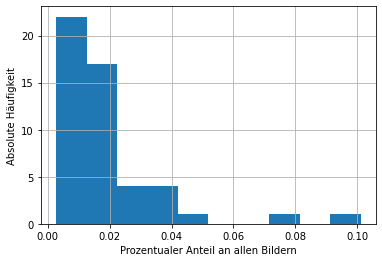

In [ ]:
plt.hist(artist_df.percentage_paintings)
plt.xlabel('Prozentualer Anteil an allen Bildern')
plt.ylabel('Absolute Häufigkeit')
plt.grid();

In [ ]:
#Künstler Albrecht Dürer wird in Dateinamen wohl unterschiedlich geschrieben
#gucken wie viele Künstler es gibt, die Albrecht heißen 
artist_df['tf'] = [True if row['name'].startswith('Albrecht') else False for i, row in artist_df.iterrows()]
artist_df.where(artist_df.tf).dropna(how = 'all')

,id,name,years,genre,nationality,bio,wikipedia,paintings,percentage_paintings,tf
19,19.0,Albrecht Dürer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328.0,0.037775,1.0


In [ ]:
#Vornamen auslesen, um generell zu sehen ob es doppelte Vornamen gibt, falls mehr 
#Namen als Albrecht Dürer angepasst werden müssen
artist_df['Vorname'] = artist_df['name'].apply(lambda x: x.split(' ')[0])
len(artist_df.Vorname.unique())

45

In [ ]:
artist_df.loc[0, 'bio']

"Amedeo Clemente Modigliani (Italian pronunciation: [ameˈdɛːo modiʎˈʎaːni]; 12 July 1884 – 24 January 1920) was an Italian Jewish painter and sculptor who worked mainly in France. He is known for portraits and nudes in a modern style characterized by elongation of faces, necks, and figures that were not received well during his lifetime but later found acceptance. Modigliani spent his youth in Italy, where he studied the art of antiquity and the Renaissance. In 1906 he moved to Paris, where he came into contact with such artists as Pablo Picasso and Constantin Brâncuși. By 1912 Modigliani was exhibiting highly stylized sculptures with Cubists of the Section d'Or group at the Salon d'Automne."

In [ ]:
#artist namen ansehen und anpassen
image_base_path = 'artists/resized'
images = os.listdir(image_base_path)
artists = set()

for image in images:
    path_ = os.path.join(image_base_path, image)
    artist = ''.join(image.split('_')[:-1])#Vor-und Nachname in Liste auslesen und mit '' joinen --> string
    if artist.startswith('Albrecht'):
        artist = 'AlbrechtDuerer'
    artists.add(artist)
len(artists)

50

### Daten einlesen und abspeichern

In [ ]:
h, w = 64, 64 #bildgröße festlegen
color = True#farbige oder schwarz-weiß bildverarbeitung

image_base_path = 'artists/resized'
images = os.listdir(image_base_path)#alle dateinamen aus resized ordner in liste images speichern
data = list()#liste in der bilder abgespeichert werden

artists = set()

for image in tqdm(images):#über jeden dateinamen iterieren
    path_ = os.path.join(image_base_path, image)
    artist = ''.join(image.split('_')[:-1])#Vor-und Nachname in Liste auslesen und mit '' joinen --> string
    if artist.startswith('Albrecht'):#spezialfall, da name aufgrund umlaut ü unterschiedlich drin ist
        artist = 'AlbrechtDuerer'
    if color:
        img = cv2.imread(path_, 1)
    else:
        img = cv2.imread(path_, 0)#schwarz weiß einlesen
    #bilder auf einheitliche größe bringen
    img = cv2.resize(img, (h,w))#dimensionen richtige reihenfolge?
    data.append((img, artist))#bild mit zugehöriger artist klasse abspeichern
    artists.add(artist)

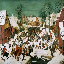

In [ ]:
cv2_imshow(data[220][0])

### Trainings- und Testbatches erzeugen

In [ ]:
def create_batches(data, batch_size = 64, color = True):
    '''
        data: liste, die bilder enthält
        batch_size: Anzahl Elemente in einem Batch
        color: True/False Wert, der angibt ob Bilder 1 oder 3 Farbchannel haben (wegen Dimensionen wichtig)
    '''
    batches = list()#liste enthält später alle erzeugten batches
    batch = list()#einzelner batch, der batch_size viele Elemente enthalten wird

    targets = list() #enthält alle batches mit targets 
    target = list()# wird behandelt wie ein einzlener batch, nur mit labeln

    random.shuffle(data)#Daten mischen, falls diese in irgendener Form geordnet sind
    for k, (d_, tar)  in enumerate(data, start = 1):#iteration über jedes Bild

        #label one-hot-encoden
        artist_id = lookup_artistid[tar]#id des artist in lookup table auslesen
        label = np.zeros(num_classes)#vektor mit num_classes vielen 0en erzeugen
        label[artist_id] = 1
        label = torch.from_numpy(label).to(device)#one hot kodierung in tensor umwandeln

        if k % batch_size == 0:#jetziger batch ist mit diesem bild voll
            if color:
                #img mit dimension (64, 64, 3), pytorch benötigt aber (3, 64, 64) --> permute (ändern der dimensionsreihenfolge)
                img = torch.from_numpy(d_/255).permute(2,0,1).to(device)#/255 --> pixelnormalisierung auf [0,1]
            else:
                #zusätzlich noch adaptiven histogrammausgleich machen, um kontraste zu erhöhen
                img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)#mit unsqueeze dimension 1 vor 64,64 hinzufügen
            batch.append(img)
            target.append(label)
            #bildtensoren mit hilfe von stack zusammenführen --> fügt batchdimension hinzu: (batchsize, color, 64,64)
            batch = torch.stack(batch)
            target = torch.stack(target)

            batches.append(batch)#batch in liste abspeichern
            targets.append(target)

            batch = list()#batch leeren
            target = list()
        else:#batch ist nicht voll --> mehr bilder hinzufügen
            if color:
                img = torch.from_numpy(d_/255).permute(2,0,1).to(device)
            else:
                img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
            batch.append(img)
            target.append(label)

    if len(batch) > 0:#kleinerer / letzter batch
        batch = torch.stack(batch)
        target = torch.stack(target)

        batches.append(batch)
        targets.append(target)
        batch = list()
    return batches, targets

random.shuffle(data)#mischen der bilder

#80/20 Train-Test-Split
train_ = data[:int(len(data)*0.8)]
test_ = data[int(len(data)*0.8):]

#zwei lookup tables erstellen, einen um artist auf nummer zu mappen, den
#anderen um id auf artist zu mappen
lookup_artistid = {artist: i for i, artist in enumerate(artists)}
lookup_idartist = {id:artist for artist, id in lookup_artistid.items()}

#train und testbatches erzeugen
train_batches, train_targets = create_batches(train_, color = color)
test_batches, test_targets = create_batches(test_, color = color, batch_size = 1)

In [ ]:
train_batches[0].shape# Dimension N, C, H, W checken

torch.Size([64, 3, 64, 64])

In [ ]:
train_targets[0].shape

torch.Size([64, 50])

## Classifier trainieren und testen

In [ ]:
def train():
    model.train()
    epoch_loss = 0
    for batch_id, batch in enumerate(train_batches):
        target = train_targets[batch_id].float()#für batch entsprechende targets auslesen

        optimizer.zero_grad()#nullen der gradienten, um falsches Updaten der Parameter zu verhindern
        out = model(batch.float())#übergeben des aktuellen batches in model und berechnung eines output mittels forward pass
        #berechnen des loss und update der model parameter
        loss = criterion(out, target)
        loss.backward()#berechnung der gradienten eines jeden parameters
        optimizer.step()#updaten der parameter mit hilfe von adam optimizer
        epoch_loss += loss.item()#aufsummieren des loss zu avgloss
    return epoch_loss/len(train_batches)

def test():
    model.eval()
    epoch_loss = 0
    acc = 0
    with torch.no_grad():#rechenleistung sparen, da .backward() nicht benötigt wird
        for batch_id, batch in enumerate(test_batches):
            target = test_targets[batch_id].float()#für batch entsprechende targets auslesen
            out = model(batch.float())#übergeben des aktuellen batches in model und berechnung eines output mittels forward pass

            out_ = torch.argmax(out)
            tar_ = torch.argmax(target)
            if out_.cpu().detach().numpy() == tar_.cpu().detach().numpy():
                acc += 1
    acc = acc/len(test_batches)#accuracy berechnen
    print('Accuracy:', acc)
    return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ArtistClassifier(nn.Module):

    def __init__(self, num_classes, color = True):
        super(ArtistClassifier, self).__init__()

        #convolution layer
        if color:#anzahl farbchannel muss angepasst werden je nach farbeingabe
            self.cnn1 = nn.Conv2d(3, 12,kernel_size=4, stride=2)#buntes bild
        else:
            self.cnn1 = nn.Conv2d(1, 12,kernel_size=4, stride=2)#graues bild

        self.cnn2 = nn.Conv2d(12, 32, kernel_size=3, stride=1)
        self.cnn3 = nn.Conv2d(32, 16, kernel_size=2, stride=1)
        self.cnn4 = nn.Conv2d(16, 4, kernel_size=4, stride=2)

        #normalisierungs- und dropout layer
        self.batch_norm1 = nn.BatchNorm2d(12)
        self.batch_norm2 = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p = 0.15)

        #fully-connected-Layer
        #self.fc = nn.Linear(4*13*13, num_classes)
        self.fc1 = nn.Linear(4*13*13, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self,x):
        x = self.batch_norm1(F.relu(self.cnn1(x.float())))
        x = F.relu(self.cnn2(x))
        x = F.relu(self.cnn3(x))
        x = self.dropout(x)
        x = F.relu(self.cnn4(x))

        x = x.flatten(start_dim = 1)#erste dimension (0) nicht flatten, da dies die batch-dimension ist
        #x = F.softmax(self.fc(x))
        x = F.relu(self.fc2(self.batch_norm2(F.relu(self.fc1(x)))))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x))
        return x

In [ ]:
model = ArtistClassifier(num_classes=num_classes, color=color).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log_df = pd.DataFrame(columns = ['epoche', 'loss', 'accuracy'])

for e in range(10000):
    print('epoche', e+1)
    loss_ = train()
    acc_ = test()
    log_df.loc[len(log_df),:] = [e+1, loss_, acc_]

epoche 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.2274035693724813
epoche 2
Accuracy: 0.23891767415083479
epoche 3
Accuracy: 0.2406447898675878
epoche 4
Accuracy: 0.25906735751295334
epoche 5
Accuracy: 0.29015544041450775
epoche 6
Accuracy: 0.2913068508923431
epoche 7
Accuracy: 0.29591249280368453
epoche 8
Accuracy: 0.3005181347150259
epoche 9
Accuracy: 0.30627518710420265
epoche 10
Accuracy: 0.30627518710420265
epoche 11
Accuracy: 0.2999424294761082
epoche 12
Accuracy: 0.27691421991940124
epoche 13
Accuracy: 0.3223949337938975
epoche 14
Accuracy: 0.2890040299366724
epoche 15
Accuracy: 0.307426597582038
epoche 16
Accuracy: 0.2895797351755901
epoche 17
Accuracy: 0.2976396085204375
epoche 18
Accuracy: 0.2654001151410478
epoche 19
Accuracy: 0.3005181347150259
epoche 20
Accuracy: 0.27806563039723664
epoche 21
Accuracy: 0.29015544041450775
epoche 22
Accuracy: 0.2849740932642487
epoche 23
Accuracy: 0.2820955670696603
epoche 24
Accuracy: 0.25964306275187105
epoche 25
Accuracy: 0.27288428324697755
epoche 26
Accuracy: 0.28267127230

Text(0.5, 1.0, 'Accuracy')

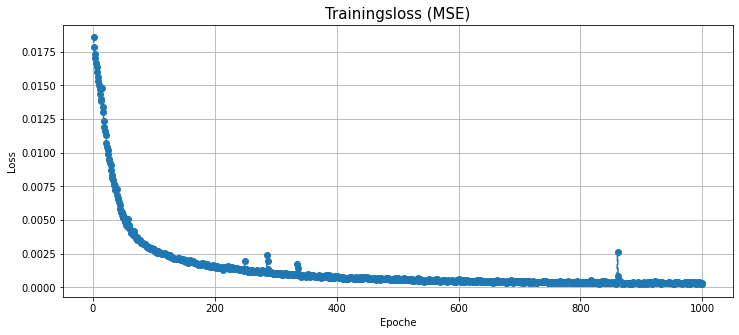

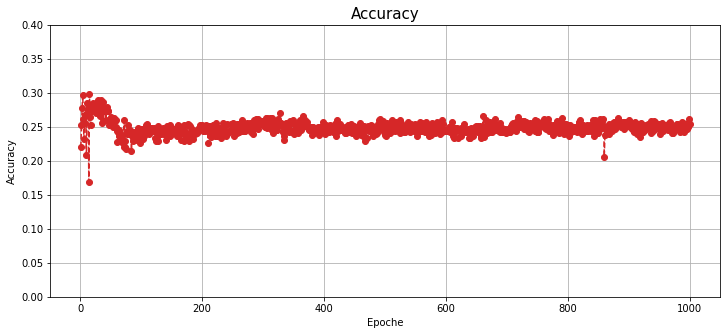

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.loss, '--', c='tab:blue')
plt.plot(log_df.epoche, log_df.loss, 'o', c='tab:blue')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid()
plt.title('Trainingsloss (MSE)', fontsize = 15)


plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.accuracy, '--', c='tab:red')
plt.plot(log_df.epoche, log_df.accuracy, 'o', c='tab:red')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.ylim(0,0.4)
plt.grid()
plt.title('Accuracy', fontsize = 15)

## Klassifikation auf schwarz-weiß Bildern

In [ ]:
h, w = 64, 64 #bildgröße festlegen
color = False#farbige oder schwarz-weiß bildverarbeitung

image_base_path = 'artists/resized'
images = os.listdir(image_base_path)#alle dateinamen aus resized ordner in liste images speichern
data = list()#liste in der bilder abgespeichert werden

artists = set()

for image in tqdm(images):#über jeden dateinamen iterieren
    path_ = os.path.join(image_base_path, image)
    artist = ''.join(image.split('_')[:-1])#Vor-und Nachname in Liste auslesen und mit '' joinen --> string
    if artist.startswith('Albrecht'):#spezialfall, da name aufgrund umlaut ü unterschiedlich drin ist
        artist = 'AlbrechtDuerer'
    if color:
        img = cv2.imread(path_, 1)
    else:
        img = cv2.imread(path_, 0)#schwarz weiß einlesen
    #bilder auf einheitliche größe bringen
    img = cv2.resize(img, (h,w))#dimensionen richtige reihenfolge?
    data.append((img, artist))#bild mit zugehöriger artist klasse abspeichern
    artists.add(artist)


random.shuffle(data)#mischen der bilder

#80/20 Train-Test-Split
train_ = data[:int(len(data)*0.8)]
test_ = data[int(len(data)*0.8):]

#zwei lookup tables erstellen, einen um artist auf nummer zu mappen, den
#anderen um id auf artist zu mappen
lookup_artistid = {artist: i for i, artist in enumerate(artists)}
lookup_idartist = {id:artist for artist, id in lookup_artistid.items()}

#train und testbatches erzeugen
train_batches, train_targets = create_batches(train_, color = color)
test_batches, test_targets = create_batches(test_, color = color, batch_size = 1)

model = ArtistClassifier(num_classes=num_classes, color=color).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log_df = pd.DataFrame(columns = ['epoche', 'loss', 'accuracy'])

for e in range(100):
    print('epoche', e+1)
    loss_ = train()
    acc_ = test()

    log_df.loc[len(log_df),:] = [e+1, loss_, acc_]


epoche 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.13874496257915947
epoche 2
Accuracy: 0.18307426597582038
epoche 3
Accuracy: 0.17731721358664365
epoche 4
Accuracy: 0.17616580310880828
epoche 5
Accuracy: 0.18307426597582038
epoche 6
Accuracy: 0.19170984455958548
epoche 7
Accuracy: 0.19458837075417387
epoche 8
Accuracy: 0.18998272884283246
epoche 9
Accuracy: 0.20840529648819806
epoche 10
Accuracy: 0.20782959124928038
epoche 11
Accuracy: 0.20782959124928038
epoche 12
Accuracy: 0.19746689694876224
epoche 13
Accuracy: 0.1871042026482441
epoche 14
Accuracy: 0.1514104778353483
epoche 15
Accuracy: 0.20092112838226828
epoche 16
Accuracy: 0.1732872769142199
epoche 17
Accuracy: 0.20149683362118595
epoche 18
Accuracy: 0.20379965457685664
epoche 19
Accuracy: 0.18652849740932642
epoche 20
Accuracy: 0.19228554979850315
epoche 21
Accuracy: 0.18652849740932642
epoche 22
Accuracy: 0.206678180771445
epoche 23
Accuracy: 0.18364997121473806
epoche 24
Accuracy: 0.1888313183649971
epoche 25
Accuracy: 0.16983304548071387
epoche 26
Accuracy: 0.19

Text(0.5, 1.0, 'Accuracy')

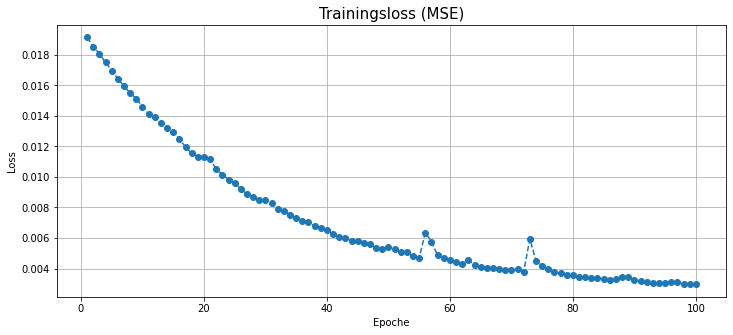

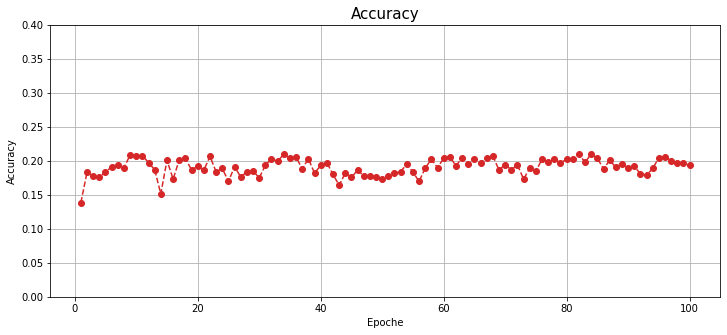

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.loss, '--', c='tab:blue')
plt.plot(log_df.epoche, log_df.loss, 'o', c='tab:blue')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid()
plt.title('Trainingsloss (MSE)', fontsize = 15)


plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.accuracy, '--', c='tab:red')
plt.plot(log_df.epoche, log_df.accuracy, 'o', c='tab:red')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.ylim(0,0.4)
plt.grid()
plt.title('Accuracy', fontsize = 15)

-- Einschub: Parameter fixieren --

In [ ]:
model = ArtistClassifier(num_classes=num_classes, color=color).to(device)
for name, weights in model.named_parameters():
    print(name)
    print(weights.requires_grad)
    if not name.startswith('fc3'):
        weights.requires_grad = False
print('\n\n')
for name, weights in model.named_parameters():
    print(name)
    print(weights.requires_grad)

cnn1.weight
True
cnn1.bias
True
cnn2.weight
True
cnn2.bias
True
cnn3.weight
True
cnn3.bias
True
cnn4.weight
True
cnn4.bias
True
batch_norm1.weight
True
batch_norm1.bias
True
batch_norm2.weight
True
batch_norm2.bias
True
fc1.weight
True
fc1.bias
True
fc2.weight
True
fc2.bias
True
fc3.weight
True
fc3.bias
True



cnn1.weight
False
cnn1.bias
False
cnn2.weight
False
cnn2.bias
False
cnn3.weight
False
cnn3.bias
False
cnn4.weight
False
cnn4.bias
False
batch_norm1.weight
False
batch_norm1.bias
False
batch_norm2.weight
False
batch_norm2.bias
False
fc1.weight
False
fc1.bias
False
fc2.weight
False
fc2.bias
False
fc3.weight
True
fc3.bias
True
